**Installing modules and Importing Libraries**

In [1]:
!pip install torch torchvision timm transformers

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
import urllib.request

from timm import create_model
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CIFAR100, SVHN, MNIST
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
from transformers import CLIPProcessor, CLIPModel
from kaggle_datasets import KaggleDatasets
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

# Task 0 (Loading the models)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])


dataset_path = './data'  # Change the path to a writeable location
cifar10_train_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform)
cifar10_test_dataset = CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size= 32, shuffle= True)

cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=32, shuffle=False)
cifar10_clip_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

print(f'Total number of images in CIFAR 10 test_loader: {len(cifar10_test_loader)}')


100%|██████████| 170498071/170498071 [00:01<00:00, 91350228.76it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Total number of images in CIFAR 10 test_loader: 313


In [4]:
def create_vit_model(num_classes):
    """Create a ViT model with a dynamic number of output classes."""
    model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

    #Freeze all layers in the VIT model
    for param in model.parameters():
        param.requires_grad = False
    # Replace the classifier head
    model.head = torch.nn.Linear(model.head.in_features, num_classes)
    return model

def create_vgg_model(num_classes):
    """Create a VGG model with a dynamic number of output classes."""
    model = vgg16(pretrained=True)
    # Freeze all layers in the VGG model
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Modify the final classifier layer to match the number of classes
    return model


def fine_tune_model(model, train_loader, num_epochs=3, alpha=1e-3):
    """Fine-tune the discriminative models on the training data."""
    print("Finetuning the discriminative model on this data")
    
    # Ensure the model is on the correct device
    model.to(device)
    model.train()

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure inputs are on the correct device

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
def init_models(num_classes):
    """Initialize ViT, VGG, and CLIP models with a dynamic number of output classes."""
    vit_model = create_vit_model(num_classes)
    vgg_model = create_vgg_model(num_classes)
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return vit_model, vgg_model, clip_model, clip_processor

In [6]:
# del vit_model
# del vgg_model
# del clip_model
# del clip_processor
# torch.cuda.empty_cache()
cifar10_vit_model, cifar10_vgg_model, clip_model, clip_processor = init_models(num_classes=10)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 213MB/s]  


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Task 2 (Evaluating the 3 models on CIFAR-10 -----> IID Dataset )

In [5]:
def evaluate_model(model, data_loader,device):
    """Evaluate the discriminative models using a basic testing loop"""
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    num_batches = len(data_loader)  # Get total number of batches

    with torch.no_grad():
        for batch_index, (images, labels) in enumerate(data_loader):

            batch_size = images.size(0)
            if batch_size < 32:
              print(f"skipping last batch of size {batch_size} --- gives shape error")
              break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Print progress every 10 batches (you can adjust this as needed)
            if batch_index % 10 == 0:
                print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    print(f'Final Accuracy: {accuracy * 100:.2f}%')
    return accuracy


def get_text_features(class_names):
    """Generate text embeddings for the given class names using CLIP."""
    # Ensure inputs are moved to the device
    inputs = clip_processor(text=class_names, return_tensors="pt", padding=True).to(device)
    
    # Make sure the model is on the same device
    clip_model.to(device)
    
    with torch.no_grad():
        # Get the text features from the model
        text_features = clip_model.get_text_features(**inputs)
    
    return text_features


def denormalize(image, mean, std):
    """Reverse the normalization applied to an image."""
    # Move mean and std to the same device as the image
    mean = torch.tensor(mean).view(3, 1, 1).to(image.device)
    std = torch.tensor(std).view(3, 1, 1).to(image.device)
    
    # Reverse the normalization
    image = image * std + mean  # Reverse normalization
    return torch.clamp(image, 0, 1)  # Clip the values to be in range [0, 1]



to_pil = transforms.ToPILImage() # Convert Tensor to PIL Image for CLIP model

def predict_image(image, means, stds):
    """Predict the class of a single image using CLIP."""
    image = image.to(device)  # Ensure the image is on the correct device
    
    # If the image has a batch dimension (4D), remove it
    if image.dim() == 4:  # Shape [B, C, H, W], remove batch dimension
        image = image.squeeze(0)
    
    # Denormalize the image and convert it to PIL
    image = to_pil(denormalize(image, means, stds))
    
    # Preprocess the image with CLIP's processor and move it to the correct device
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    
    # Get image features using CLIP's image encoder
    with torch.no_grad():
        image_features = clip_model.get_image_features(inputs.pixel_values)
    
    return image_features





def evaluate_clip_model(data_loader, class_names,device, means, stds):
    """Evaluate the zero shot CLIP model using similairty matrix and loss func (no training)"""
    text_features = get_text_features(class_names)
    correct = 0
    total = 0
    num_batches = len(data_loader)  # Get total number of batches

    for batch_index, (images, labels) in enumerate(data_loader):
        image = images[0]  # For batch size 1
        true_label = labels[0].item()
        image_features = predict_image(image,means,stds)

        # Compute similarity between image and all text features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        similarity = torch.matmul(image_features, text_features.T)

        # Predict the class
        predicted_class = similarity.argmax().item()
        if predicted_class == true_label:
            correct += 1
        total += 1

        # Print progress every 500 batches (you can adjust this as needed)
        if batch_index % 500 == 0:
            print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    return accuracy

Evaluating Vit on Cifar 10

In [8]:
print('Evaluating the Discriminative Models...')
print("Finetuning Vit model")
fine_tune_model(cifar10_vit_model,cifar10_train_loader)
# print(f"ViT Train Accuracy on CIFAR 10: {vit_train_accuracy * 100:.2f}%")

cifar10_vit_accuracy = evaluate_model(cifar10_vit_model, cifar10_test_loader,device)
print(f"ViT Accuracy on CIFAR 10: {cifar10_vit_accuracy * 100:.2f}%")


Evaluating the Discriminative Models...
Finetuning Vit model
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 0.1809
Epoch [2/3], Loss: 0.1265
Epoch [3/3], Loss: 0.1149
Batch 1/313 - Accuracy: 100.00%
Batch 11/313 - Accuracy: 94.60%
Batch 21/313 - Accuracy: 95.83%
Batch 31/313 - Accuracy: 96.37%
Batch 41/313 - Accuracy: 95.88%
Batch 51/313 - Accuracy: 95.77%
Batch 61/313 - Accuracy: 95.75%
Batch 71/313 - Accuracy: 95.69%
Batch 81/313 - Accuracy: 95.60%
Batch 91/313 - Accuracy: 95.40%
Batch 101/313 - Accuracy: 95.20%
Batch 111/313 - Accuracy: 95.24%
Batch 121/313 - Accuracy: 95.14%
Batch 131/313 - Accuracy: 95.23%
Batch 141/313 - Accuracy: 95.32%
Batch 151/313 - Accuracy: 95.20%
Batch 161/313 - Accuracy: 95.17%
Batch 171/313 - Accuracy: 95.19%
Batch 181/313 - Accuracy: 95.25%
Batch 191/313 - Accuracy: 95.27%
Batch 201/313 - Accuracy: 95.29%
Batch 211/313 - Accuracy: 95.38%
Batch 221/313 - Accuracy: 95.33%
Batch 231/313 - Accuracy: 95.32%
Batch 241/313 - Accuracy: 95.3

Evaluating Vgg on Cifar 10

In [9]:
print("Finetuning vgg model")
fine_tune_model(cifar10_vgg_model,cifar10_train_loader)
# print(f"Vgg Train Accuracy on CIFAR 10: {vgg_train_accuracy * 100:.2f}%")
cifar10_vgg_accuracy = evaluate_model(cifar10_vgg_model, cifar10_test_loader,device)
print(f"VGG Accuracy on CIFAR 10: {cifar10_vgg_accuracy * 100:.2f}%")




Finetuning vgg model
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 0.8935
Epoch [2/3], Loss: 0.6660
Epoch [3/3], Loss: 0.5776
Batch 1/313 - Accuracy: 87.50%
Batch 11/313 - Accuracy: 80.97%
Batch 21/313 - Accuracy: 81.99%
Batch 31/313 - Accuracy: 81.85%
Batch 41/313 - Accuracy: 82.55%
Batch 51/313 - Accuracy: 82.60%
Batch 61/313 - Accuracy: 82.43%
Batch 71/313 - Accuracy: 82.66%
Batch 81/313 - Accuracy: 82.48%
Batch 91/313 - Accuracy: 82.80%
Batch 101/313 - Accuracy: 82.70%
Batch 111/313 - Accuracy: 82.80%
Batch 121/313 - Accuracy: 82.77%
Batch 131/313 - Accuracy: 82.97%
Batch 141/313 - Accuracy: 83.40%
Batch 151/313 - Accuracy: 83.44%
Batch 161/313 - Accuracy: 83.31%
Batch 171/313 - Accuracy: 83.19%
Batch 181/313 - Accuracy: 83.22%
Batch 191/313 - Accuracy: 83.18%
Batch 201/313 - Accuracy: 83.27%
Batch 211/313 - Accuracy: 83.35%
Batch 221/313 - Accuracy: 83.43%
Batch 231/313 - Accuracy: 83.63%
Batch 241/313 - Accuracy: 83.60%
Batch 251/313 - Accuracy: 83.59%
Batch

Evaluating Clip on Cifar 10

In [10]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print('Evaluating the Contrastive Model...')
cifar10_clip_accuracy = evaluate_clip_model(cifar10_clip_test_loader, cifar10_classes, device, means=(0.4914, 0.4822, 0.4465),stds=(0.247, 0.2435, 0.2616))
print(f'CLIP (Zero-Shot) Accuracy on CIFAR 10: {cifar10_clip_accuracy * 100:.2f}%')



Evaluating the Contrastive Model...
Batch 1/10000 - Accuracy: 0.00%
Batch 501/10000 - Accuracy: 84.43%
Batch 1001/10000 - Accuracy: 85.21%
Batch 1501/10000 - Accuracy: 85.88%
Batch 2001/10000 - Accuracy: 86.36%
Batch 2501/10000 - Accuracy: 86.13%
Batch 3001/10000 - Accuracy: 85.67%
Batch 3501/10000 - Accuracy: 85.63%
Batch 4001/10000 - Accuracy: 85.65%
Batch 4501/10000 - Accuracy: 85.56%
Batch 5001/10000 - Accuracy: 85.42%
Batch 5501/10000 - Accuracy: 85.24%
Batch 6001/10000 - Accuracy: 85.17%
Batch 6501/10000 - Accuracy: 84.85%
Batch 7001/10000 - Accuracy: 84.65%
Batch 7501/10000 - Accuracy: 84.87%
Batch 8001/10000 - Accuracy: 84.96%
Batch 8501/10000 - Accuracy: 85.03%
Batch 9001/10000 - Accuracy: 84.97%
Batch 9501/10000 - Accuracy: 85.01%
CLIP (Zero-Shot) Accuracy on CIFAR 10: 85.00%


# Task 3 (Evaluating the 3 models on CIFAR-100 & PACS ----> OOD Datasets )

In [11]:
import os

# List the contents of the /kaggle/input directory
print(os.listdir('/kaggle/input/pacs-data/pacs_data/pacs_data'))


['cartoon', 'sketch', 'art_painting', 'photo']


In [12]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

# Define the PACS data root directory
pacs_data_root = '/kaggle/input/pacs-data/pacs_data/pacs_data'

# Define transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet mean and std
])

# Get the list of domains (subfolders in pacs_data_root)
domains = [d for d in os.listdir(pacs_data_root) if os.path.isdir(os.path.join(pacs_data_root, d))]
print("Domains found in PACS dataset:", domains)

# For each domain, create separate DataLoader for training and testing
domain_loaders = {}

for domain in domains:
    # Load the dataset for the current domain
    domain_path = os.path.join(pacs_data_root, domain)
    domain_dataset = datasets.ImageFolder(root=domain_path, transform=transform)
    
    # Split into train and test (let's assume an 80-20 split for train-test)
    train_size = int(0.8 * len(domain_dataset))
    test_size = len(domain_dataset) - train_size
    train_dataset, test_dataset = random_split(domain_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
    
    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Store the DataLoader for each domain
    domain_loaders[domain] = {
        'train': train_loader,
        'test': test_loader
    }

    print(f"Domain: {domain} - Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# # Example of how to access the DataLoader for a specific domain (e.g., 'art_painting')
# train_loader_art = domain_loaders['art_painting']['train']
# test_loader_art = domain_loaders['art_painting']['test']


Domains found in PACS dataset: ['cartoon', 'sketch', 'art_painting', 'photo']
Domain: cartoon - Train samples: 1875, Test samples: 469
Domain: sketch - Train samples: 3143, Test samples: 786
Domain: art_painting - Train samples: 1292, Test samples: 324
Domain: photo - Train samples: 1336, Test samples: 334


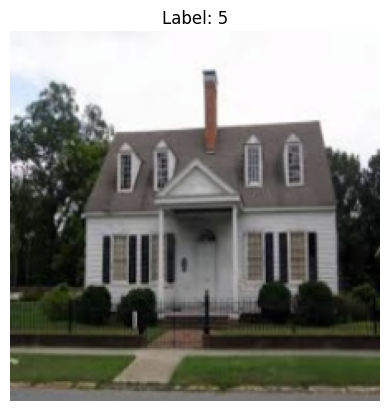

In [13]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to display a random image from the DataLoader
def show_random_image(dataloader):
    # Get a random batch of images
    images, labels = next(iter(dataloader))
    
    # Pick a random index from the batch
    random_idx = random.randint(0, images.size(0) - 1)
    
    # Get the random image and its corresponding label
    image = images[random_idx].numpy().transpose(1, 2, 0)  # Convert to H x W x C format
    label = labels[random_idx].item()

    # Unnormalize the image (reverse the normalization process)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)  # Ensure pixel values are within [0, 1]

    # Display the image and label
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

# Example: Call the function to show a random image from the train_loader
show_random_image(train_loader)


In [23]:
# del vit_model
# del vgg_model
# del clip_model
# del clip_processor
# torch.cuda.empty_cache()
pacs_classes = [
    "dog", "elephant", "giraffe", "guitar","horse", "house", "person"
]
vit_model, vgg_model, clip_model, clip_processor = init_models(num_classes=7)

In [24]:
from torch.utils.data import ConcatDataset

# Loop through each domain for training
for domain in domains:
    print(f"Training on domain: {domain}")
    
    # 1. Load the training data for the current domain
    domain_path = os.path.join(pacs_data_root, domain)
    train_dataset = datasets.ImageFolder(root=domain_path, transform=transform)
    
    # Split into train and test sets for this domain
    train_size = int(0.8 * len(train_dataset))
    test_size = len(train_dataset) - train_size
    train_split, _ = random_split(train_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
    
    # 2. Combine all other domains for testing
    test_datasets = []
    for other_domain in domains:
        if other_domain != domain:
            other_domain_path = os.path.join(pacs_data_root, other_domain)
            test_dataset = datasets.ImageFolder(root=other_domain_path, transform=transform)
            test_datasets.append(test_dataset)
    
    # Combine all the test datasets from the other domains
    combined_test_dataset = ConcatDataset(test_datasets)
    test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)
    testclip_loader = DataLoader(combined_test_dataset, batch_size=1, shuffle=False)
    
    # 3. Finetune and evaluate the ViT model
    print(f"Finetuning ViT model on {domain}")
    fine_tune_model(vit_model, train_loader)
    
    vit_pacs_accuracy = evaluate_model(vit_model, test_loader, device)
    print(f'ViT model accuracy on all other domains: {vit_pacs_accuracy * 100:.2f}% except {domain}')
    
    # 4. Finetune and evaluate the VGG model
    print(f"Finetuning VGG model on {domain}")
    fine_tune_model(vgg_model, train_loader)
    
    vgg_pacs_accuracy = evaluate_model(vgg_model, test_loader, device)
    print(f'VGG model accuracy on all other domains: {vgg_pacs_accuracy * 100:.2f}% except {domain}')
    
    # 5. Optionally evaluate the CLIP model on the combined test set
    print(f'Evaluating the Contrastive Model (CLIP) on all other domains... except {domain}')
    
    clip_pacs_accuracy = evaluate_clip_model(testclip_loader, pacs_classes, device, means=(0.485, 0.456, 0.406), stds=(0.229, 0.224, 0.225))
    print(f'CLIP model accuracy on all other domains: {clip_pacs_accuracy * 100:.2f}% ')


Training on domain: cartoon
Finetuning ViT model on cartoon
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 0.7837
Epoch [2/3], Loss: 0.2824
Epoch [3/3], Loss: 0.2060
Batch 1/226 - Accuracy: 78.12%
Batch 11/226 - Accuracy: 37.78%
Batch 21/226 - Accuracy: 30.06%
Batch 31/226 - Accuracy: 29.44%
Batch 41/226 - Accuracy: 27.97%
Batch 51/226 - Accuracy: 26.35%
Batch 61/226 - Accuracy: 22.03%
Batch 71/226 - Accuracy: 19.06%
Batch 81/226 - Accuracy: 18.63%
Batch 91/226 - Accuracy: 18.20%
Batch 101/226 - Accuracy: 17.23%
Batch 111/226 - Accuracy: 16.08%
Batch 121/226 - Accuracy: 18.34%
Batch 131/226 - Accuracy: 18.06%
Batch 141/226 - Accuracy: 17.09%
Batch 151/226 - Accuracy: 16.04%
Batch 161/226 - Accuracy: 15.06%
Batch 171/226 - Accuracy: 14.38%
Batch 181/226 - Accuracy: 15.69%
Batch 191/226 - Accuracy: 19.67%
Batch 201/226 - Accuracy: 23.37%
Batch 211/226 - Accuracy: 26.94%
Batch 221/226 - Accuracy: 30.08%
skipping last batch of size 15 --- gives shape error
Final Accura

# Loading SVHN dataset

In [16]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))  # SVHN mean and std
])

# Load the dataset
svhn_train_dataset = SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test_dataset = SVHN(root='./data', split='test', download=True, transform=transform)

# DataLoaders
svhn_train_loader = DataLoader(svhn_train_dataset, batch_size=32, shuffle=True)
svhn_test_loader = DataLoader(svhn_test_dataset, batch_size=32, shuffle=False)
clip_svhn_test_loader = DataLoader(svhn_test_dataset, batch_size=1, shuffle=False)


# Check unique labels in the train set
train_labels = torch.tensor(svhn_train_dataset.labels)
unique_classes_train = torch.unique(train_labels)
print(f'Unique classes in the train dataset: {unique_classes_train}')

# Check unique labels in the test set
test_labels = torch.tensor(svhn_test_dataset.labels)
unique_classes_test = torch.unique(test_labels)
print(f'Unique classes in the test dataset: {unique_classes_test}')


100%|██████████| 182040794/182040794 [02:35<00:00, 1167849.52it/s]


100%|██████████| 64275384/64275384 [00:58<00:00, 1096361.07it/s]


Unique classes in the train dataset: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Unique classes in the test dataset: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [17]:
print(svhn_test_dataset.labels)
print(type(svhn_train_dataset.labels[0]))
svhn_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
unique_classes_test = ["zero","one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]


[5 2 1 ... 7 6 7]
<class 'numpy.int64'>


In [18]:
# del vit_model
# del vgg_model
# del clip_model
# del clip_processor
# torch.cuda.empty_cache()
# cifar100_classes = [
#     "apple", "aquarium_fish", "banana", "bear", "bed", "bee", "beetle", "bottle", "bowl", "boy",
#     "bridge", "bus", "cake", "can", "car", "cell_phone", "chair", "clock", "cocktail", "computer",
#     "cone", "cup", "dolphin", "elephant", "frog", "girl", "hamster", "house", "kangaroo", "keyboard",
#     "lamp", "lawn_mower", "leopard", "lion", "lizard", "man", "map", "motorcycle", "mouse", "mushroom",
#     "oak_tree", "orange", "orchid", "otter", "palm_tree", "peacock", "pear", "pencil", "pickup_truck", "pine_tree",
#     "plain", "plate", "purse", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea",
#     "seal", "shark", "shoes", "skateboard", "skis", "skyscraper", "snake", "spider", "squirrel", "streetcar",
#     "sunflower", "sweet_pepper", "table", "tank", "telephone", "tiger", "train", "truck", "umbrella", "watch"
# ]
vit_model, vgg_model, clip_model, clip_processor = init_models(num_classes=10)

In [19]:
# Evaluating the Discriminative Models on SVHN dataset
print('Evaluating the Discriminative Models on SVHN dataset...')
print("Finetuning Vit model")
fine_tune_model(vit_model, svhn_train_loader)
vit_svhn_accuracy = evaluate_model(vit_model, svhn_test_loader, device)
print(f'VIT model accuracy on SVHN: {vit_svhn_accuracy * 100:.2f}%')

print("Finetuning Vgg model")
fine_tune_model(vgg_model, svhn_train_loader)
vgg_svhn_accuracy = evaluate_model(vgg_model, svhn_test_loader, device)
print(f'VGG model accuracy on SVHN: {vgg_svhn_accuracy * 100:.2f}%')



Evaluating the Discriminative Models on SVHN dataset...
Finetuning Vit model
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 1.4985
Epoch [2/3], Loss: 1.3327
Epoch [3/3], Loss: 1.2944
Batch 1/814 - Accuracy: 53.12%
Batch 11/814 - Accuracy: 57.67%
Batch 21/814 - Accuracy: 55.51%
Batch 31/814 - Accuracy: 55.75%
Batch 41/814 - Accuracy: 56.71%
Batch 51/814 - Accuracy: 56.68%
Batch 61/814 - Accuracy: 56.81%
Batch 71/814 - Accuracy: 57.09%
Batch 81/814 - Accuracy: 57.29%
Batch 91/814 - Accuracy: 57.25%
Batch 101/814 - Accuracy: 57.39%
Batch 111/814 - Accuracy: 57.52%
Batch 121/814 - Accuracy: 57.70%
Batch 131/814 - Accuracy: 57.68%
Batch 141/814 - Accuracy: 57.71%
Batch 151/814 - Accuracy: 57.84%
Batch 161/814 - Accuracy: 57.73%
Batch 171/814 - Accuracy: 57.75%
Batch 181/814 - Accuracy: 57.89%
Batch 191/814 - Accuracy: 58.02%
Batch 201/814 - Accuracy: 57.68%
Batch 211/814 - Accuracy: 57.75%
Batch 221/814 - Accuracy: 57.71%
Batch 231/814 - Accuracy: 57.71%
Batch 241/814 -

In [20]:
# Evaluating the Contrastive Model on SVHN dataset
print('Evaluating the Contrastive Model on SVHN dataset...')
clip_svhn_accuracy = evaluate_clip_model(clip_svhn_test_loader, unique_classes_test, device, 
                                         means=(0.4377, 0.4438, 0.4728), 
                                         stds=(0.1980, 0.2010, 0.1970))
print(f'CLIP (Zero-Shot) Accuracy on SVHN: {clip_svhn_accuracy * 100:.2f}%')

Evaluating the Contrastive Model on SVHN dataset...
Batch 1/26032 - Accuracy: 0.00%
Batch 501/26032 - Accuracy: 17.56%
Batch 1001/26032 - Accuracy: 17.48%
Batch 1501/26032 - Accuracy: 16.59%
Batch 2001/26032 - Accuracy: 16.84%
Batch 2501/26032 - Accuracy: 16.55%
Batch 3001/26032 - Accuracy: 16.39%
Batch 3501/26032 - Accuracy: 16.45%
Batch 4001/26032 - Accuracy: 16.57%
Batch 4501/26032 - Accuracy: 16.51%
Batch 5001/26032 - Accuracy: 16.42%
Batch 5501/26032 - Accuracy: 16.62%
Batch 6001/26032 - Accuracy: 16.61%
Batch 6501/26032 - Accuracy: 16.52%
Batch 7001/26032 - Accuracy: 16.50%
Batch 7501/26032 - Accuracy: 16.44%
Batch 8001/26032 - Accuracy: 16.55%
Batch 8501/26032 - Accuracy: 16.54%
Batch 9001/26032 - Accuracy: 16.66%
Batch 9501/26032 - Accuracy: 16.66%
Batch 10001/26032 - Accuracy: 16.67%
Batch 10501/26032 - Accuracy: 16.63%
Batch 11001/26032 - Accuracy: 16.57%
Batch 11501/26032 - Accuracy: 16.48%
Batch 12001/26032 - Accuracy: 16.57%
Batch 12501/26032 - Accuracy: 16.69%
Batch 13001

In [6]:
!pip install gdown
import gdown
import zipfile
import os

def download_and_extract_zip(google_drive_link, output_filename, extract_folder):
    """
    Downloads a zip file from Google Drive and extracts its contents.

    Args:
    - google_drive_link (str): The Google Drive link to the file.
    - output_filename (str): The name for the downloaded zip file.
    - extract_folder (str): The path to extract the zip contents.
    
    Returns:
    - None
    """
    # Download the zip file
    gdown.download(google_drive_link, output_filename, quiet=False)

    # Create the extraction folder if it doesn't already exist
    os.makedirs(extract_folder, exist_ok=True)

    # Manually unzip the contents into the extraction folder
    with zipfile.ZipFile(output_filename, 'r') as zip_ref:
        # List the contents of the zip file
        file_list = zip_ref.namelist()
#         print(f"Contents of the zip file: {file_list}")
        
        # Extract the contents to the specified folder
        zip_ref.extractall(extract_folder)

    # Verify that the files are extracted
    print(f"Contents of the extraction folder: {os.listdir(extract_folder)}")




# Task 4 Color bias Evaluation on Cifar10

Downloading Color bias dataset

In [26]:


import gdown
# 'https://drive.google.com/file/d/1z1u1tvknavJNfYqZmZsMghavDpIh6AVf/view?usp=drive_link'

# Corrected Google Drive link
google_drive_link = "https://drive.google.com/uc?id=1z1u1tvknavJNfYqZmZsMghavDpIh6AVf"
output_filename = '/kaggle/working/colored_cifar10.zip'
extract_folder = '/kaggle/working/colored_cifar10'

download_and_extract_zip(google_drive_link, output_filename, extract_folder)

Downloading...
From (original): https://drive.google.com/uc?id=1z1u1tvknavJNfYqZmZsMghavDpIh6AVf
From (redirected): https://drive.google.com/uc?id=1z1u1tvknavJNfYqZmZsMghavDpIh6AVf&confirm=t&uuid=ecfb4e25-b6b7-4fcf-8f5b-6453172959b8
To: /kaggle/working/colored_cifar10.zip
100%|██████████| 69.3M/69.3M [00:01<00:00, 49.4MB/s]


Contents of the extraction folder: ['content']


Getting labels of the bias dataset

In [27]:
labels_output ="/kaggle/working/colored_cifar10/content/generated_dataset/labels.txt"
# Parse the labels file into a dictionary
labels_dict = {}

with open(labels_output, 'r') as file:
    for line in file:
        filename, label = line.strip().split()  # Split the filename and label by space
        labels_dict[filename] = int(label)  # Store the label as an integer

# labels_dict

Visualisation

In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Function to load, display, and store tensor images from a folder
# Function to load, resize, and display tensor images
def load_and_display_images(tensors_folder, display_limit=5):
    """
    Loads, resizes, and displays images from tensor files in a given folder.
    Also stores the loaded images as tensors for future use.

    Args:
    - tensors_folder (str): Path to the folder containing tensor files.
    - display_limit (int): Number of images to display.

    Returns:
    - loaded_tensors (list): List of loaded and resized image tensors.
    """
    
    # Transform to resize the tensor directly
    resize = transforms.Resize((224, 224))  # Resize to 224x224

    # List to store the loaded image tensors
    loaded_tensors = []

    # List all .pt files in the folder
    tensor_files = [f for f in os.listdir(tensors_folder) if f.endswith('.pt')]

    # Loop through and load all the tensor images, but display only the first `display_limit` images
    for i, tensor_file in enumerate(tensor_files):
        tensor_path = os.path.join(tensors_folder, tensor_file)
        
        # Load the tensor
        tensor_image = torch.load(tensor_path)

        # Remove extra batch dimension if present
        if tensor_image.dim() == 4:
            tensor_image = tensor_image.squeeze(0)

        # Resize the tensor to 224x224
        tensor_image = resize(tensor_image)

        # Store the resized tensor
        loaded_tensors.append(tensor_image)

        # Convert tensor to numpy array for displaying
        image_array = tensor_image.permute(1, 2, 0).cpu().numpy()  # Convert from CHW to HWC

        # Display only up to `display_limit` images
        if i < display_limit:
            plt.imshow(image_array)
            plt.title(f"Image: {tensor_file}")
            plt.axis('off')
            plt.show()
        else:
            break  # Stop after displaying `display_limit` images

    return loaded_tensors

# Example usage


# You can now use the `loaded_tensors` for input to the model


In [ ]:
tensors_folder = "/kaggle/working/colored_cifar10/content/generated_dataset/images"
loaded_tensors_colored_cifar10 = load_and_display_images(tensors_folder, display_limit=5)

Actual resizing & preprocessing

In [8]:
from sklearn.metrics import accuracy_score
# Function to preprocess tensors (apply resizing and normalization)
resize_transform = transforms.Resize((224, 224))  # Resize transform

normalize_transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

def preprocess_tensor(tensor_image):
    # Resize and normalize the tensor images
    if tensor_image.dim() == 4:  # Remove batch dimension if present
        tensor_image = tensor_image.squeeze(0)
    
    # Resize to 224x224 (if needed)
    tensor_image = resize_transform(tensor_image)
    
    # Apply normalization only
    tensor_image = normalize_transform(tensor_image)
    
    # Add batch dimension back for model input
    return tensor_image.unsqueeze(0).to(device)

# Function to evaluate model on custom images with ground truth labels
def evaluate_model_on_custom_images(model, model_name, labels_dict, tensor_files, tensors_folder):
    model.to(device)  # Move the model to the same device as the data
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    ground_truth_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for tensor_file in tensor_files:
            tensor_path = os.path.join(tensors_folder, tensor_file)
            
            # Load the tensor (already loaded as a PyTorch tensor)
            tensor_image = torch.load(tensor_path)
            
            # Preprocess the image (resize, normalize, and move to the correct device)
            processed_image = preprocess_tensor(tensor_image)
            
            # Pass through the model (ensure both the model and the input are on the same device)
            outputs = model(processed_image)
            
            # Get the predicted class (argmax to get the index of the highest score)
            _, predicted = outputs.max(1)
            predicted_class = predicted.item()
            all_predictions.append(predicted_class)
            
            # Get the ground truth label from the labels_dict using the tensor filename
            true_label = labels_dict[tensor_file]  # Ensure the tensor filename matches the keys in labels_dict
            ground_truth_labels.append(true_label)
    
    # Calculate accuracy
    accuracy = accuracy_score(ground_truth_labels, all_predictions)
    print(f"{model_name} Accuracy on Custom Images: {accuracy * 100:.2f}%")
    
    return accuracy


def evaluate_clip_model_on_custom_data(tensor_files, class_names, labels_dict, means, stds, device):
    """Evaluate the zero-shot CLIP model using the custom tensor data."""
    
    # Generate text embeddings for CIFAR-10 class names
    text_features = get_text_features(class_names)  # Function should generate CLIP text features
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize text embeddings
    
    correct = 0
    total = 0
    num_files = len(tensor_files)  # Total number of tensor files
    
    for i, tensor_file in enumerate(tensor_files):
        # Load the custom tensor image
        tensor_path = os.path.join(tensors_folder, tensor_file)
        tensor_image = torch.load(tensor_path).to(device)  # Load the tensor image and move to device
        
        # Get the true label for this image
        true_label = labels_dict[tensor_file]  # The correct label as an integer
        
        # Preprocess the image (apply CLIP preprocessing using predict_image)
        image_features = predict_image(tensor_image, means, stds)  # Preprocess and normalize image
        
        # Normalize image features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity between image and all text features
        similarity = torch.matmul(image_features, text_features.T)
        
        # Predict the class (the index of the most similar text feature)
        predicted_class = similarity.argmax().item()
        
        # Compare prediction to ground truth
        if predicted_class == true_label:
            correct += 1
        total += 1
        
        # Print progress every 50 files (or adjust as needed)
        if i % 50 == 0:
            print(f'Processed {i+1}/{num_files} - Accuracy: { (correct/total) * 100:.2f}%')
    
    # Calculate final accuracy
    accuracy = correct / total
    return accuracy





In [30]:
tensors_folder = '/kaggle/working/colored_cifar10/content/generated_dataset/images'
tensor_files = [f for f in os.listdir(tensors_folder) if f.endswith('.pt')]

# accuracy = evaluate_model_on_custom_images(model, "Model Name", labels_dict, tensor_files, tensors_folder)

vit_accuracy_cifar10_color_bias=evaluate_model_on_custom_images(cifar10_vit_model, "ViT", labels_dict,tensor_files, tensors_folder)
print("Vit accuracy on Color bias data",vit_accuracy_cifar10_color_bias)


vgg_accuracy_cifar10_color_bias = evaluate_model_on_custom_images(cifar10_vgg_model, "Vgg", labels_dict,tensor_files, tensors_folder)
print("Vgg accuracy on Color bias data",vgg_accuracy_cifar10_color_bias)

/tmp/ipykernel_30/4014180221.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


ViT Accuracy on Custom Images: 54.70%
Vit accuracy on Color bias data 0.547


/tmp/ipykernel_30/4014180221.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


Vgg Accuracy on Custom Images: 41.34%
Vgg accuracy on Color bias data 0.4134


In [31]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]




# Call the function for evaluation
# Make `device` a keyword argument:
clip_accuracy_custom_cifar10 = evaluate_clip_model_on_custom_data(tensor_files, cifar10_classes, labels_dict, means=(0.4914, 0.4822, 0.4465), stds=(0.247, 0.2435, 0.2616), device=device)

print(f"CLIP Accuracy on Custom Data: {clip_accuracy_custom_cifar10 * 100:.2f}%")

Processed 1/10000 - Accuracy: 100.00%


/tmp/ipykernel_30/4014180221.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path).to(device)  # Load the tensor image and move to devi

Processed 51/10000 - Accuracy: 33.33%
Processed 101/10000 - Accuracy: 39.60%
Processed 151/10000 - Accuracy: 41.72%
Processed 201/10000 - Accuracy: 40.80%
Processed 251/10000 - Accuracy: 41.04%
Processed 301/10000 - Accuracy: 41.20%
Processed 351/10000 - Accuracy: 43.02%
Processed 401/10000 - Accuracy: 40.65%
Processed 451/10000 - Accuracy: 41.24%
Processed 501/10000 - Accuracy: 40.92%
Processed 551/10000 - Accuracy: 40.47%
Processed 601/10000 - Accuracy: 40.60%
Processed 651/10000 - Accuracy: 41.01%
Processed 701/10000 - Accuracy: 41.37%
Processed 751/10000 - Accuracy: 41.81%
Processed 801/10000 - Accuracy: 41.82%
Processed 851/10000 - Accuracy: 41.60%
Processed 901/10000 - Accuracy: 41.29%
Processed 951/10000 - Accuracy: 41.54%
Processed 1001/10000 - Accuracy: 41.46%
Processed 1051/10000 - Accuracy: 42.06%
Processed 1101/10000 - Accuracy: 42.05%
Processed 1151/10000 - Accuracy: 42.31%
Processed 1201/10000 - Accuracy: 42.05%
Processed 1251/10000 - Accuracy: 42.21%
Processed 1301/10000

In [32]:
vit_color_bias = vit_accuracy_cifar10_color_bias/cifar10_vit_accuracy
vgg_color_bias = vgg_accuracy_cifar10_color_bias/cifar10_vgg_accuracy
clip_color_bias = clip_accuracy_custom_cifar10/cifar10_clip_accuracy



print('vit_color_bias',vit_color_bias)
print('vgg_color_bias',vgg_color_bias)
print('clip_color_bias',clip_color_bias)

vit_color_bias 0.5734797857817915
vgg_color_bias 0.49282216119402983
clip_color_bias 0.5174117647058823


In [33]:
print('cifar10_vit_accuracy',cifar10_vit_accuracy)
print('cifar10_vgg_accuracy',cifar10_vgg_accuracy)
print('cifar10_clip_accuracy',cifar10_clip_accuracy)
print('vit_accuracy_cifar10_color_bias',vit_accuracy_cifar10_color_bias)
print("vgg_accuracy_cifar10_color_bias",vgg_accuracy_cifar10_color_bias)
print('clip_accuracy_custom_cifar10',clip_accuracy_custom_cifar10)

cifar10_vit_accuracy 0.9538261217948718
cifar10_vgg_accuracy 0.8388421474358975
cifar10_clip_accuracy 0.85
vit_accuracy_cifar10_color_bias 0.547
vgg_accuracy_cifar10_color_bias 0.4134
clip_accuracy_custom_cifar10 0.4398


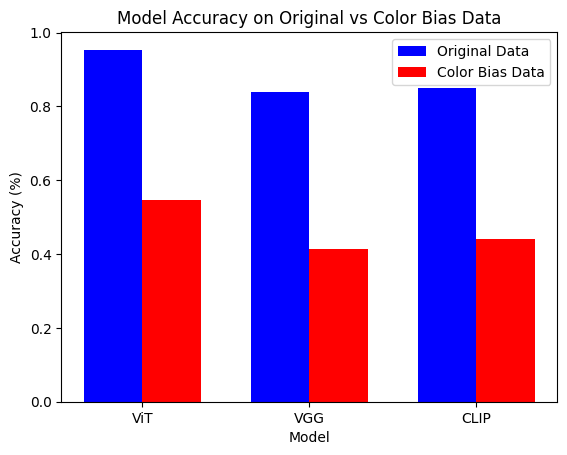

In [34]:
import matplotlib.pyplot as plt

# Given accuracies (in percentage)
# cifar10_vit_accuracy = 80.5  # Replace with the actual accuracy
# vit_accuracy_cifar10_color_bias = 55.2  # Replace with the actual accuracy

# cifar10_vgg_accuracy = 78.0  # Replace with the actual accuracy
# vgg_accuracy_cifar10_color_bias = 50.1  # Replace with the actual accuracy

# cifar10_clip_accuracy = 82.3  # Replace with the actual accuracy
# clip_accuracy_custom_cifar10 = 60.7  # Replace with the actual accuracy

# Bar Graph
models = ['ViT', 'VGG', 'CLIP']
original_accuracies = [cifar10_vit_accuracy, cifar10_vgg_accuracy, cifar10_clip_accuracy]
color_bias_accuracies = [vit_accuracy_cifar10_color_bias, vgg_accuracy_cifar10_color_bias, clip_accuracy_custom_cifar10]

x = range(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x, original_accuracies, width, label='Original Data', color='blue')
bar2 = ax.bar([i + width for i in x], color_bias_accuracies, width, label='Color Bias Data', color='red')

# Labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy on Original vs Color Bias Data')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(models)
ax.legend()

# Show the bar graph
plt.show()


# Task 4 Texture bias Evaluation on Cifar10

In [35]:
# https://drive.google.com/file/d/1QmPYOxT4dKDEHev04YycEXAbiRCRVRQA/view?usp=drive_link
# Corrected Google Drive link
google_drive_link = "https://drive.google.com/uc?id=1QmPYOxT4dKDEHev04YycEXAbiRCRVRQA"
output_filename = '/kaggle/working/cifar_texture_bias_styled_images.zip'
extract_folder = '/kaggle/working/cifar_texture_bias_styled_images'



download_and_extract_zip(google_drive_link, output_filename, extract_folder)


Downloading...
From (original): https://drive.google.com/uc?id=1QmPYOxT4dKDEHev04YycEXAbiRCRVRQA
From (redirected): https://drive.google.com/uc?id=1QmPYOxT4dKDEHev04YycEXAbiRCRVRQA&confirm=t&uuid=a68bea1e-bbba-4c57-8efa-52045285bcaa
To: /kaggle/working/cifar_texture_bias_styled_images.zip
100%|██████████| 547M/547M [00:06<00:00, 78.6MB/s] 


Contents of the extraction folder: ['content']


In [ ]:
# os.listdir("/kaggle/working/cifar_texture_bias_styled_images/content/generated_dataset/images")
# "/kaggle/working/cifar_texture_bias_styled_images/content/generated_dataset/images"
# "/kaggle/working/cifar_texture_bias_styled_images/content/generated_dataset/labels.txt"

In [36]:
labels_output ="/kaggle/working/cifar_texture_bias_styled_images/content/generated_dataset/labels.txt"
# Parse the labels file into a dictionary
labels_dict = {}

with open(labels_output, 'r') as file:
    for line in file:
        filename, label = line.strip().split()  # Split the filename and label by space
        labels_dict[filename] = int(label)  # Store the label as an integer
        
# labels_dict

/tmp/ipykernel_30/1977401646.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


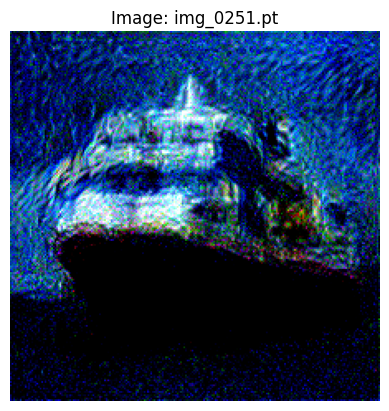

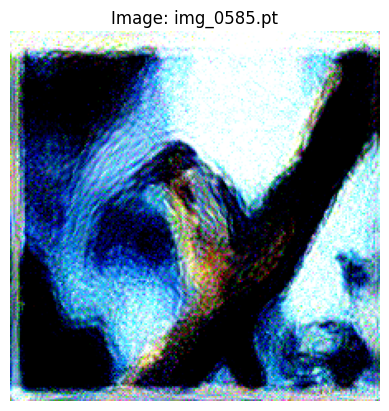

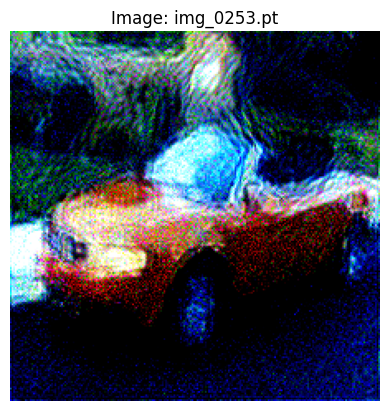

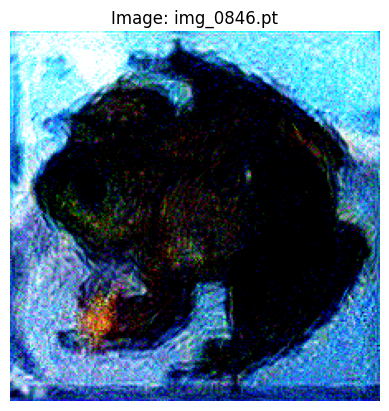

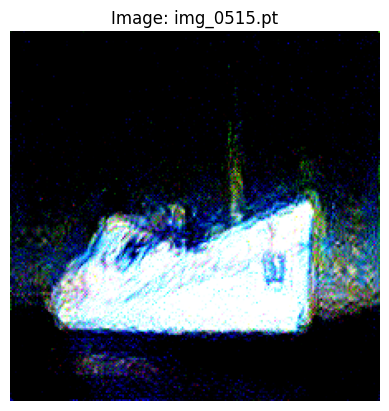

In [37]:
# Path to the folder containing the tensor files
tensors_folder ="/kaggle/working/cifar_texture_bias_styled_images/content/generated_dataset/images"
tensor_files = [f for f in os.listdir(tensors_folder) if f.endswith('.pt')]
loaded_tensors_texture_bias_data = load_and_display_images(tensors_folder, display_limit=5)



In [38]:
vit_accuracy_cifar10_texture_bias=evaluate_model_on_custom_images(cifar10_vit_model, "ViT", labels_dict,tensor_files, tensors_folder)
print("Vit accuracy on Color bias data",vit_accuracy_cifar10_texture_bias)


vgg_accuracy_cifar10_texture_bias = evaluate_model_on_custom_images(cifar10_vgg_model, "Vgg", labels_dict,tensor_files, tensors_folder)
print("Vgg accuracy on Color bias data",vgg_accuracy_cifar10_texture_bias)

cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]




# Call the function for evaluation
# Make `device` a keyword argument:
clip_accuracy_custom_cifar10_texture_bais = evaluate_clip_model_on_custom_data(tensor_files, cifar10_classes, labels_dict, means=(0.4914, 0.4822, 0.4465), stds=(0.247, 0.2435, 0.2616), device=device)

print(f"CLIP Accuracy on Custom Data: {clip_accuracy_custom_cifar10_texture_bais * 100:.2f}%")

/tmp/ipykernel_30/4014180221.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


ViT Accuracy on Custom Images: 23.40%
Vit accuracy on Color bias data 0.234


/tmp/ipykernel_30/4014180221.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path)


Vgg Accuracy on Custom Images: 38.70%
Vgg accuracy on Color bias data 0.387
Processed 1/1000 - Accuracy: 100.00%


/tmp/ipykernel_30/4014180221.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_image = torch.load(tensor_path).to(device)  # Load the tensor image and move to devi

Processed 51/1000 - Accuracy: 60.78%
Processed 101/1000 - Accuracy: 57.43%
Processed 151/1000 - Accuracy: 56.95%
Processed 201/1000 - Accuracy: 57.21%
Processed 251/1000 - Accuracy: 58.17%
Processed 301/1000 - Accuracy: 57.48%
Processed 351/1000 - Accuracy: 57.83%
Processed 401/1000 - Accuracy: 58.10%
Processed 451/1000 - Accuracy: 58.98%
Processed 501/1000 - Accuracy: 58.08%
Processed 551/1000 - Accuracy: 58.62%
Processed 601/1000 - Accuracy: 59.40%
Processed 651/1000 - Accuracy: 59.60%
Processed 701/1000 - Accuracy: 59.91%
Processed 751/1000 - Accuracy: 59.92%
Processed 801/1000 - Accuracy: 60.42%
Processed 851/1000 - Accuracy: 60.87%
Processed 901/1000 - Accuracy: 60.27%
Processed 951/1000 - Accuracy: 60.46%
CLIP Accuracy on Custom Data: 60.00%


In [39]:
texture_bias_vit = vit_accuracy_cifar10_texture_bias/cifar10_vit_accuracy
texture_bias_vgg = vgg_accuracy_cifar10_texture_bias/cifar10_vgg_accuracy
texture_bias_clip = clip_accuracy_custom_cifar10_texture_bais/cifar10_clip_accuracy

print(f'color bias for vit: {texture_bias_vit}')
print(f'color bias for vgg: {texture_bias_vgg}')
print(f'color bias for clip: {texture_bias_clip}')

color bias for vit: 0.24532773285729287
color bias for vgg: 0.4613502089552239
color bias for clip: 0.7058823529411765


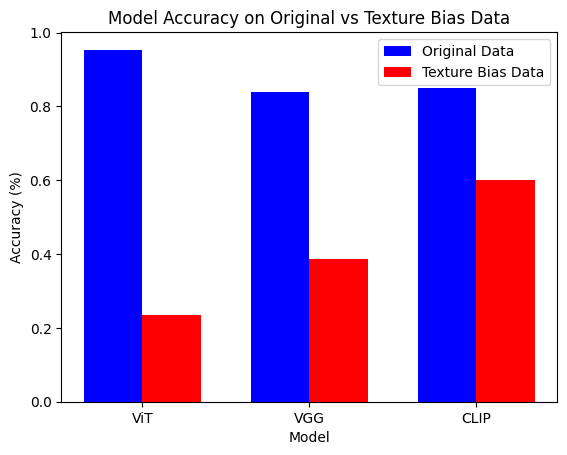

In [49]:
import matplotlib.pyplot as plt

# Given accuracies (in percentage)
# cifar10_vit_accuracy = 80.5  # Replace with the actual accuracy
# vit_accuracy_cifar10_color_bias = 55.2  # Replace with the actual accuracy

# cifar10_vgg_accuracy = 78.0  # Replace with the actual accuracy
# vgg_accuracy_cifar10_color_bias = 50.1  # Replace with the actual accuracy

# cifar10_clip_accuracy = 82.3  # Replace with the actual accuracy
# clip_accuracy_custom_cifar10 = 60.7  # Replace with the actual accuracy

# Bar Graph
models = ['ViT', 'VGG', 'CLIP']
original_accuracies = [cifar10_vit_accuracy, cifar10_vgg_accuracy, cifar10_clip_accuracy]
color_bias_accuracies = [vit_accuracy_cifar10_texture_bias, vgg_accuracy_cifar10_texture_bias, clip_accuracy_custom_cifar10_texture_bais]

x = range(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x, original_accuracies, width, label='Original Data', color='blue')
bar2 = ax.bar([i + width for i in x], color_bias_accuracies, width, label='Texture Bias Data', color='red')

# Labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy on Original vs Texture Bias Data')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(models)
ax.legend()

# Show the bar graph
plt.show()


# Task 4 Shape bias Evaluation on Ccco

In [9]:
import torch
import os
import torch.nn.functional as F

# Function to load labels
def load_labels(labels_path):
    labels_dict = {}
    with open(labels_path, 'r') as file:
        for line in file:
            filename, label = line.strip().split()  # Split the filename and label
            labels_dict[filename] = int(label)  # Store label as an integer
    return labels_dict

# Function to convert RGB to grayscale and back to 3-channel RGB format
def rgb_to_grayscale_and_back(tensor):
    # If the tensor has 3 channels (RGB), convert to grayscale by averaging across the channels
    if tensor.shape[0] == 3:
        grayscale_tensor = tensor.mean(dim=0, keepdim=True)  # Mean across the color channels (C dimension)
        rgb_grayscale_tensor = torch.cat([grayscale_tensor] * 3, dim=0)  # Convert back to 3 channels
    else:
        rgb_grayscale_tensor = tensor  # Already grayscale or single channel
    return rgb_grayscale_tensor

# Function to resize and convert bias images, leaving other images unchanged
def process_images(images_path, labels_dict, target_size=(500, 500), is_bias=False):
    image_data = []  # Store processed images
    image_labels = []  # Store corresponding labels

    for image_file in os.listdir(images_path):
        if image_file.endswith('.pt'):
            # Load the image tensor
            image_tensor = torch.load(os.path.join(images_path, image_file))

            # If the image is bias, convert to grayscale, resize to 500x500, and convert back to RGB
            if is_bias:
                if image_tensor.dim() == 4:  # If it's in the form [1, C, H, W], remove batch dimension
                    image_tensor = image_tensor.squeeze(0)

                # Convert to grayscale and back to RGB, then resize
                processed_image = rgb_to_grayscale_and_back(image_tensor)
                processed_image = F.interpolate(processed_image.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)
                processed_image = processed_image.squeeze(0)  # Remove batch dimension after resizing
            else:
                processed_image = image_tensor  # Leave non-bias images unchanged

            # Get the label for the image
            label = labels_dict.get(image_file, None)
            if label is not None:
                image_data.append(processed_image)
                image_labels.append(label)

    return image_data, image_labels

In [10]:
# Paths to the directories
bias_images_path = "/kaggle/input/shape-bias-evaluation-on-coco-dataset/coco_test_bias/images"
bias_labels_path = "/kaggle/input/shape-bias-evaluation-on-coco-dataset/coco_test_bias/labels.txt"
original_images_path = "/kaggle/input/shape-bias-evaluation-on-coco-dataset/coco_test_original/coco_test_original/images"
original_labels_path = "/kaggle/input/shape-bias-evaluation-on-coco-dataset/coco_test_original/coco_test_original/labels.txt"
train_images_path = "/kaggle/input/shape-bias-evaluation-on-coco-dataset/coco_train/coco_train/images"
train_labels_path = "/kaggle/input/shape-bias-evaluation-on-coco-dataset/coco_train/coco_train/labels.txt"

# Load labels
bias_labels = load_labels(bias_labels_path)
original_labels = load_labels(original_labels_path)
train_labels = load_labels(train_labels_path)



# Process bias images (convert to grayscale, resize to 500x500, and back to RGB)
bias_data, bias_labels = process_images(bias_images_path, bias_labels, target_size=(500, 500), is_bias=True)

# Process original and train images (leave unchanged)
original_data, original_labels = process_images(original_images_path, original_labels, is_bias=False)
train_data, train_labels = process_images(train_images_path, train_labels, is_bias=False)

/tmp/ipykernel_30/1950252528.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensor = torch.load(os.path.join(images_path, image_file))


# Visualization

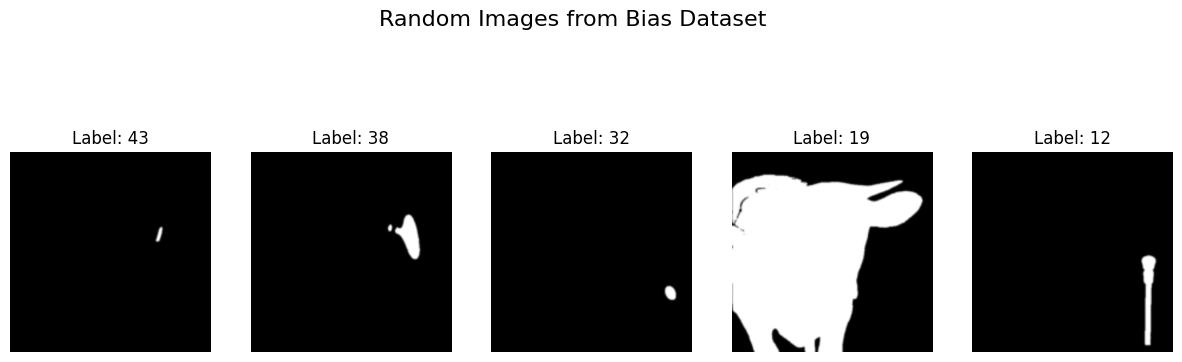

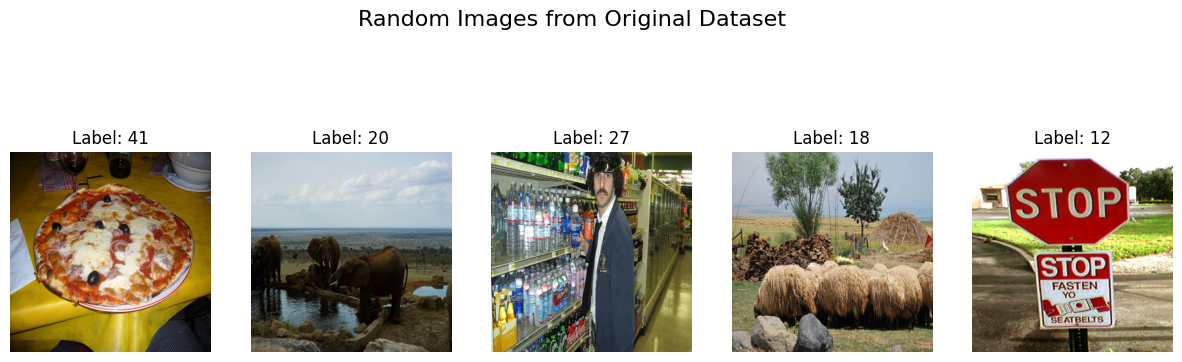

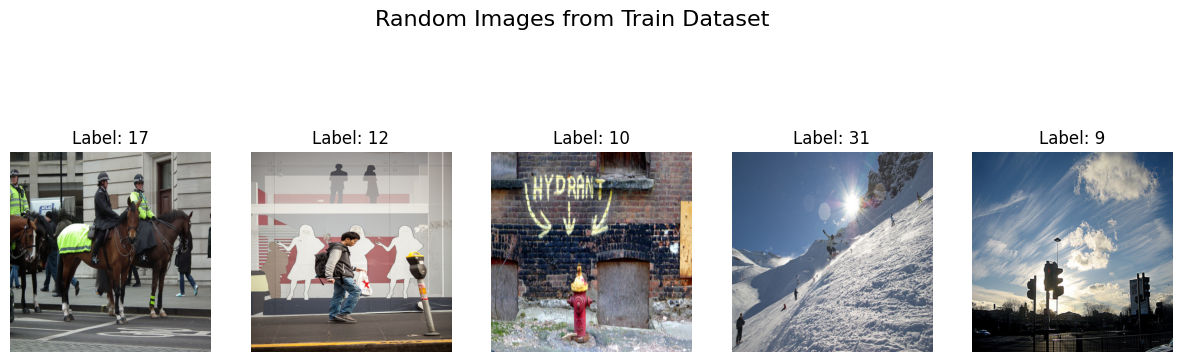

In [11]:
import matplotlib.pyplot as plt
import random

# Function to visualize images
def visualize_images(data, labels, dataset_name, num_images=5, grayscale=False):
    """
    Visualize random images from the dataset.
    data: List of image tensors
    labels: Corresponding labels
    dataset_name: Name of the dataset (for the title)
    num_images: Number of images to display
    grayscale: If True, display images in grayscale (black and white)
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f'Random Images from {dataset_name} Dataset', fontsize=16)
    
    for i in range(num_images):
        random_idx = random.randint(0, len(data) - 1)  # Pick a random image index
        image = data[random_idx].cpu().numpy()  # Convert to numpy for display
        
        if grayscale:
            # If grayscale, average the color channels and set cmap to 'gray'
            image = image.mean(axis=0)  # Average across color channels (C dimension)
            axes[i].imshow(image, cmap='gray')
        else:
            # Transpose the image tensor from [C, H, W] to [H, W, C] for display
            image = image.transpose(1, 2, 0)
            axes[i].imshow(image)
        
        label = labels[random_idx]  # Get the corresponding label
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')  # Turn off the axis

    plt.show()

# Visualize random images from each dataset
# For bias dataset (display in grayscale)
visualize_images(bias_data, bias_labels, dataset_name='Bias', num_images=5, grayscale=True)

# For original and train datasets (leave as RGB)
visualize_images(original_data, original_labels, dataset_name='Original', num_images=5)
visualize_images(train_data, train_labels, dataset_name='Train', num_images=5)


In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create a function to wrap data and labels into TensorDataset
def create_dataloader(images, labels, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.stack(images), torch.tensor(labels))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader



In [13]:
coco_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", 
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", 
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", 
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", 
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", 
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", 
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", 
    "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse", 
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", 
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", 
    "toothbrush"
]

coco_vit_model, coco_vgg_model, clip_model, clip_processor = init_models(num_classes=80)

# coco_classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'handbag', 'tie', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'cup', 'fork', 'knife', 'bowl', 'apple']

# coco_vit_model, coco_vgg_model, clip_model, clip_processor = init_models(num_classes=41)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 52.1MB/s] 


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
import torchvision.transforms.functional as TF

# Define the transform for training and evaluation (resize to 224x224)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))  # Example: CIFAR10 normalization
])

def preprocess_for_model(images, labels, transform):
    """Preprocess images and labels to resize and normalize them for the model."""
    processed_images = []
    for img in images:
        img_pil = transforms.ToPILImage()(img)  # Convert tensor to PIL image for resizing
        
        # If the image is grayscale (1 channel), convert it to RGB (3 channels)
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')
        
        img_resized = transform(img_pil)
        processed_images.append(img_resized)
    
    return processed_images, labels

# Process bias, original, and train data for model input (resize to 224x224)
bias_data, bias_labels = preprocess_for_model(bias_data, bias_labels, train_transform)
original_data, original_labels = preprocess_for_model(original_data, original_labels, train_transform)
train_data, train_labels = preprocess_for_model(train_data, train_labels, train_transform)

# Create dataloaders after preprocessing
coco_train_loader = create_dataloader(train_data, train_labels, batch_size=32, shuffle=True)
coco_original_test_loader = create_dataloader(original_data, original_labels, batch_size=32, shuffle=False)
coco_original_test_loader_coco = create_dataloader(original_data, original_labels, batch_size=1, shuffle=False)
coco_bias_test_loader = create_dataloader(bias_data, bias_labels, batch_size=32, shuffle=False)

In [15]:
# coco_train_loader, coco_original_test_loader, coco_bias_test_loader

print("Finetuning ViT model on Coco")
fine_tune_model(coco_vit_model, coco_train_loader)
vit_coco_accuracy = evaluate_model(coco_vit_model, coco_original_test_loader, device)
print(f'VIT model accuracy on Coco: {vit_coco_accuracy * 100:.2f}%')

print("Finetuning VGG model on Coco")
fine_tune_model(coco_vgg_model, coco_train_loader)
vgg_coco_accuracy = evaluate_model(coco_vgg_model, coco_original_test_loader, device)
print(f'VGG model accuracy on Coco: {vgg_coco_accuracy * 100:.2f}%')


vit_bias_coco_accuracy = evaluate_model(coco_vit_model, coco_bias_test_loader, device)
print(f'\nVIT model accuracy on bias Coco: {vit_bias_coco_accuracy * 100:.2f}%')


vgg_bias_coco_accuracy = evaluate_model(coco_vgg_model, coco_bias_test_loader, device)
print(f'\nVGG model accuracy on Coco: {vgg_bias_coco_accuracy * 100:.2f}%')


Finetuning ViT model on Coco
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 2.1530
Epoch [2/3], Loss: 0.8995
Epoch [3/3], Loss: 0.6063
Batch 1/15 - Accuracy: 68.75%
Batch 11/15 - Accuracy: 63.35%
skipping last batch of size 2 --- gives shape error
Final Accuracy: 63.62%
VIT model accuracy on Coco: 63.62%
Finetuning VGG model on Coco
Finetuning the discriminative model on this data
Epoch [1/3], Loss: 3.0535
Epoch [2/3], Loss: 1.8313
Epoch [3/3], Loss: 1.3728
Batch 1/15 - Accuracy: 50.00%
Batch 11/15 - Accuracy: 41.48%
skipping last batch of size 2 --- gives shape error
Final Accuracy: 41.96%
VGG model accuracy on Coco: 41.96%
Batch 1/15 - Accuracy: 6.25%
Batch 11/15 - Accuracy: 6.53%
skipping last batch of size 2 --- gives shape error
Final Accuracy: 6.03%

VIT model accuracy on bias Coco: 6.03%
Batch 1/15 - Accuracy: 3.12%
Batch 11/15 - Accuracy: 3.69%
skipping last batch of size 2 --- gives shape error
Final Accuracy: 4.24%

VGG model accuracy on Coco: 4.24%


In [16]:
vit_shape_bias = vit_bias_coco_accuracy/vit_coco_accuracy
vgg_shape_bias = vgg_bias_coco_accuracy/vgg_coco_accuracy
print(f'shape bias for vit: {vit_shape_bias}')
print(f'shape bias for vgg: {vgg_shape_bias}')
# print(f'color bias for clip: {stlye_bias_clip}')

shape bias for vit: 0.09473684210526316
shape bias for vgg: 0.10106382978723405


In [17]:
print('Evaluating Clip on Coco dataset...')
clip_coco_accuracy = evaluate_clip_model(coco_original_test_loader_coco, coco_classes, device, 
                                         means=(0.4377, 0.4438, 0.4728), 
                                         stds=(0.1980, 0.2010, 0.1970))
print(f'CLIP (Zero-Shot) Accuracy on SVHN: {clip_coco_accuracy * 100:.2f}%')

Evaluating Clip on Coco dataset...
Batch 1/450 - Accuracy: 0.00%
CLIP (Zero-Shot) Accuracy on SVHN: 49.56%


In [18]:
print('Evaluating Clip on Shape biased Coco dataset...')
clip_shape_bias_coco_accuracy = evaluate_clip_model(coco_bias_test_loader, coco_classes, device, 
                                         means=(0.4377, 0.4438, 0.4728), 
                                         stds=(0.1980, 0.2010, 0.1970))
print(f'CLIP (Zero-Shot) Accuracy on SVHN: {clip_shape_bias_coco_accuracy * 100:.2f}%')

Evaluating Clip on Shape biased Coco dataset...
Batch 1/15 - Accuracy: 100.00%
CLIP (Zero-Shot) Accuracy on SVHN: 20.00%
